In [1]:
# importing necessary libraries and classes
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

import nltk
import numpy as np
import tensorflow as tf
import os
import sys
import zipfile

# run it before checking your cuda's version and Tensorflow's version to see if match
print("Tensorflow version {}".format(tf.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version 2.8.0
Num GPUs Available:  1


In [16]:
#Hyperparameter tuning 
BATCH_SIZE = 50
NUM_EPOCHS = 100
GLOVE_EMBEDDING_SIZE = 50
HIDDEN_UNITS = 32
MAX_INPUT_SEQ_LENGTH = 30
MAX_TARGET_SEQ_LENGTH = 30
MAX_VOCAB_SIZE = 10000
DATA_SET_NAME = 'my_data'
DATA_DIR_PATH = 'my-data'
WEIGHT_FILE_PATH = 'support files/model-weights.h5'
GLOVE_MODEL = "glove/glove.6B." + str(GLOVE_EMBEDDING_SIZE) + "d.txt"
WHITELIST = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'


In [3]:
#defines the valid characters for the chatbot
def in_white_list(_word):
    for char in _word:
        if char in WHITELIST:
            return True

    return False


#it is done to load the glove embeddings file     
def load_glove_embeddings():
    _word2em = {}
    file = open(GLOVE_MODEL, mode='rt', encoding='utf8')
    for line in file:
        words = line.strip().split()
        word = words[0]
        embeds = np.array(words[1:], dtype=np.float32)
        _word2em[word] = embeds
    file.close()
    return _word2em

word2em = load_glove_embeddings()

target_counter = Counter()

In [4]:
input_texts = []
target_texts = []

for file in os.listdir(DATA_DIR_PATH):
    filepath = os.path.join(DATA_DIR_PATH, file)
    if os.path.isfile(filepath):
        print('processing file: ', file)
        lines = open(filepath, 'rt', encoding='utf8').read().split('\n')
        prev_words = []
        for line in lines:

            if line.startswith('- - '):
                prev_words = []

            if line.startswith('- - ') or line.startswith('  - '):
                line = line.replace('- - ', '')
                line = line.replace('  - ', '')
                next_words = [w.lower() for w in nltk.word_tokenize(line)]
                next_words = [w for w in next_words if in_white_list(w)]
                if len(next_words) > MAX_TARGET_SEQ_LENGTH:
                    next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]

                if len(prev_words) > 0:
                    input_texts.append(prev_words)

                    target_words = next_words[:]
                    target_words.insert(0, 'start')
                    target_words.append('end')
                    for w in target_words:
                        target_counter[w] += 1
                    target_texts.append(target_words)

                prev_words = next_words

processing file:  admissions.yml
processing file:  bot_info.yml
processing file:  Division_of_Student_Affairs.yml
processing file:  emotion.yml
processing file:  film.yml
processing file:  food.yml
processing file:  greetings.yml
processing file:  health.yml
processing file:  IT.yml
processing file:  jokes_fun.yml
processing file:  psychology.yml
processing file:  school life.yml
processing file:  Sport_games.yml


In [5]:
for idx, (input_words, target_words) in enumerate(zip(input_texts, target_texts)):
    if idx > 10:
        break
    print([input_words, target_words])

target_word2idx = dict()
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1

if 'unknown' not in target_word2idx:
    target_word2idx['unknown'] = 0

target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_decoder_tokens = len(target_idx2word)

np.save('support files/target-word2idx.npy', target_word2idx)
np.save('support files/target-idx2word.npy', target_idx2word)


[['what', 'are', 'the', 'fall', '2021', 'admissions', 'requirements', '?'], ['start', 'depending', 'on', 'class', 'rank', ',', 'required', 'sat', 'scores', 'must', 'be', 'between', '1030-1250', '.', 'required', 'act', 'scores', 'must', 'be', 'between', '20-26', '.', 'students', 'in', 'the', 'top', 'ten', 'percent', 'do', 'not', 'have', 'end']]
[['what', 'if', 'i', 'am', 'unable', 'to', 'take', 'the', 'sat/act', 'for', 'fall', '2021', 'admission', '?'], ['start', 'prospective', 'students', 'who', 'apply', 'without', 'sat', 'or', 'act', 'scores', 'will', 'be', 'individually', 'reviewed', 'and', 'evaluated', 'for', 'admission', 'based', 'on', 'high', 'school', 'gpa', ',', 'class', 'rank', 'and', 'other', 'academic', 'criteria', '.', 'end']]
[['how', 'do', 'i', 'send', 'my', 'ap', 'scores', 'for', 'fall', '2021', 'admission', '?'], ['start', 'sign', 'in', 'to', 'my', 'ap', 'using', 'your', 'college', 'board', 'username', 'and', 'password', '.', 'go', 'to', 'my', 'ap', 'profile', ',', 'and'

In [6]:
input_texts_word2em = []

encoder_max_seq_length = 0
decoder_max_seq_length = 0

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        emb = np.zeros(shape=GLOVE_EMBEDDING_SIZE)
        if w in word2em:
            emb = word2em[w]
        encoder_input_wids.append(emb)

    input_texts_word2em.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
np.save('support files/word-glove-context.npy', context)


{'num_decoder_tokens': 1938, 'encoder_max_seq_length': 30, 'decoder_max_seq_length': 32}


In [17]:
def generate_batch(input_word2em_data, output_text_data):
    num_batches = len(input_word2em_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = pad_sequences(input_word2em_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, GLOVE_EMBEDDING_SIZE))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = target_word2idx['unknown']  # default unknown
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    if w in word2em:
                        decoder_input_data_batch[lineIdx, idx, :] = word2em[w]
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

#Encoder layers,inputs,outputs
encoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='encoder_inputs')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm1',return_sequences=True)
# encoder_lstm2 = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm2',return_sequences=True, dropout = 0.25)
# x = encoder_lstm1(encoder_inputs)
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
encoder_states = [encoder_state_h, encoder_state_c]

#Decoder layers - input,output,LSTM,Dense
decoder_inputs = Input(shape=(None, GLOVE_EMBEDDING_SIZE), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
# decoder_lstm2 = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm2', dropout = 0.25)
# y = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)
#model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.008)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
json = model.to_json()
open('support files/word-architecture.json', 'w').write(json)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None, 50)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None, 50)]   0           []                               
                                                                                                  
 encoder_lstm1 (LSTM)           [(None, None, 32),   10624       ['encoder_inputs[0][0]']         
                                 (None, 32),                                                      
                                 (None, 32)]                                                      
                                                                                            

In [18]:
#train_test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(input_texts_word2em, target_texts, test_size=0.2)

#execution and updation of wt in batches
train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)

train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

#saving of model at checks through checkpoint
checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)



In [19]:
#fitting of chatbot moel
history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,
                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])



#final weights saved at desired location
model.save_weights(WEIGHT_FILE_PATH)

Epoch 1/100


C:\Users\jerry\AppData\Local\Temp/ipykernel_23316/1191838687.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,


14/14 [==============================] - 6s 145ms/step - loss: 2.6645 - accuracy: 0.0131 - val_loss: 2.3812 - val_accuracy: 0.0312
Epoch 2/100
14/14 [==============================] - 1s 56ms/step - loss: 2.2943 - accuracy: 0.0312 - val_loss: 2.4232 - val_accuracy: 0.0312
Epoch 3/100
14/14 [==============================] - 1s 56ms/step - loss: 2.3209 - accuracy: 0.0312 - val_loss: 2.4328 - val_accuracy: 0.0312
Epoch 4/100
14/14 [==============================] - 1s 54ms/step - loss: 2.3115 - accuracy: 0.0312 - val_loss: 2.4186 - val_accuracy: 0.0312
Epoch 5/100
14/14 [==============================] - 1s 61ms/step - loss: 2.3070 - accuracy: 0.0312 - val_loss: 2.4269 - val_accuracy: 0.0312
Epoch 6/100
14/14 [==============================] - 1s 57ms/step - loss: 2.3064 - accuracy: 0.0312 - val_loss: 2.4245 - val_accuracy: 0.0312
Epoch 7/100
14/14 [==============================] - 1s 51ms/step - loss: 2.3025 - accuracy: 0.0312 - val_loss: 2.4237 - val_accuracy: 0.0312
Epoch 8/100
14/14

14/14 [==============================] - 1s 53ms/step - loss: 2.1860 - accuracy: 0.0467 - val_loss: 2.3827 - val_accuracy: 0.0456
Epoch 59/100
14/14 [==============================] - 1s 49ms/step - loss: 2.1839 - accuracy: 0.0468 - val_loss: 2.3827 - val_accuracy: 0.0442
Epoch 60/100
14/14 [==============================] - 1s 52ms/step - loss: 2.1817 - accuracy: 0.0467 - val_loss: 2.3826 - val_accuracy: 0.0452
Epoch 61/100
14/14 [==============================] - 1s 50ms/step - loss: 2.1798 - accuracy: 0.0466 - val_loss: 2.3830 - val_accuracy: 0.0448
Epoch 62/100
14/14 [==============================] - 1s 49ms/step - loss: 2.1780 - accuracy: 0.0470 - val_loss: 2.3835 - val_accuracy: 0.0446
Epoch 63/100
14/14 [==============================] - 1s 48ms/step - loss: 2.1764 - accuracy: 0.0474 - val_loss: 2.3840 - val_accuracy: 0.0452
Epoch 64/100
14/14 [==============================] - 1s 54ms/step - loss: 2.1751 - accuracy: 0.0473 - val_loss: 2.3858 - val_accuracy: 0.0450
Epoch 65/100

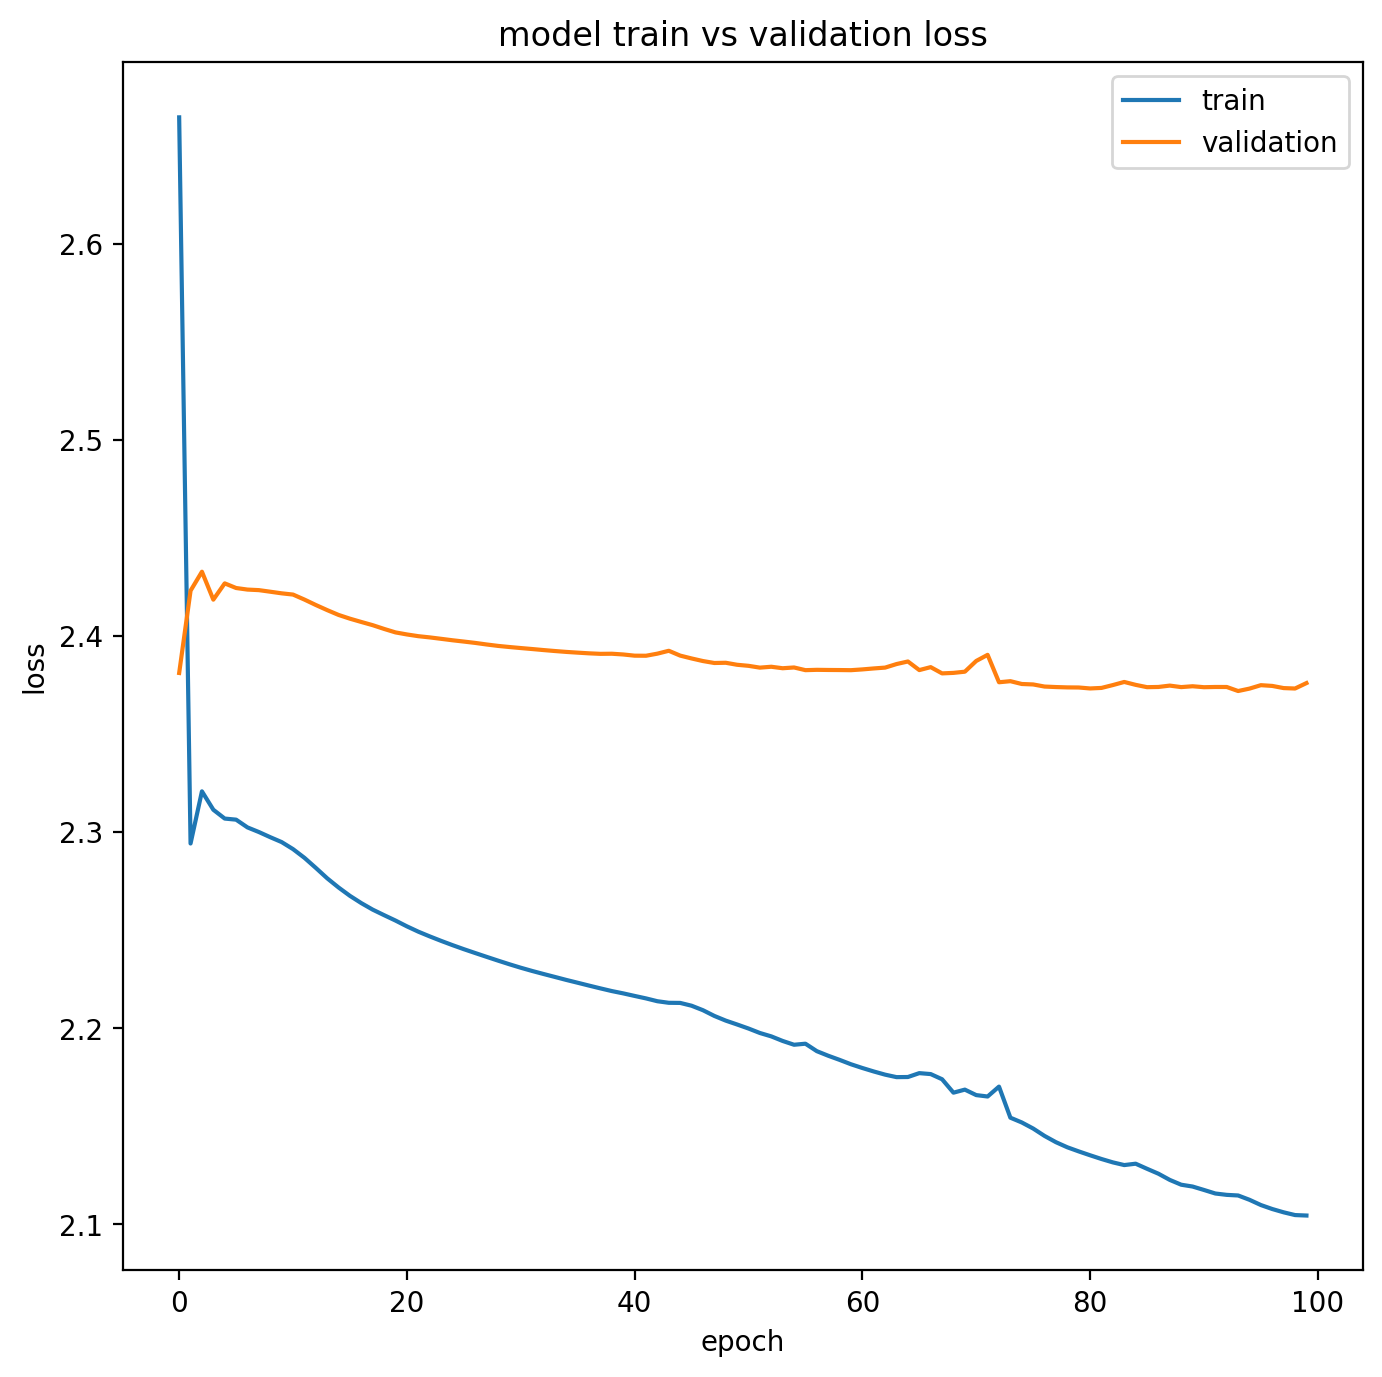

In [20]:
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from numpy import array

# plot train and validation loss
plt.figure(figsize=(8,8),dpi=200)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()
